In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from IPython.display import clear_output
import time

from numpy.ctypeslib import ndpointer
import ctypes

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import glob

# 입력 데이터
각 데이터는 분단위의 시계열 데이터로 나타난다.  
결측값은 interpolate로 채워 넣었으며, 총 1815958개의 행을 가지고 있다.  

In [2]:
tickers = ['BTC', 'ETH', 'XRP', 'DOGE','ETC']
path = './data/'+tickers[0]+'-M.csv'
df = pd.read_csv(path,parse_dates=[0], index_col=[0])
df.drop('value',axis=1, inplace=True)
df.head()

,open,high,low,close,volume
2018-09-19 23:50:00,7180000.0,7187000.0,7180000.0,7187000.0,0.504830
2018-09-19 23:51:00,7186000.0,7188000.0,7181000.0,7181000.0,0.882076
2018-09-19 23:52:00,7184000.0,7188000.0,7183000.0,7188000.0,0.486359
2018-09-19 23:53:00,7188000.0,7188000.0,7188000.0,7188000.0,0.002734
2018-09-19 23:54:00,7188000.0,7188000.0,7187000.0,7187000.0,0.006945


### pred 열
원하는 변동률에 도달하는 기간을 나타낸다.  
상승의 경우 양수로, 하강의 경우 음수로 나타내며, 각 절대값은 도달하는 기간이다.  
예) per(df, 0.05) 에서 2490의 경우 2490분 후에 5%만큼 상승한다는 것을 나타낸다.  

Python의 경우 속도가 느려 C언어를 이용한 동적 라이브러리를 사용하였다. 

In [3]:
_dll = ctypes.CDLL('setPred.dll')
_doublepp = ndpointer(dtype=np.uintp, ndim=1, flags='C')

_pred = _dll.pred_period
_pred.argtypes = [ctypes.c_float, ctypes.c_int, _doublepp, _doublepp]
_pred.restype = None

def per(x, per):
    y =  np.zeros_like(x[['close']], dtype = int)
    x_np = x[['open','high','low','close']].to_numpy(dtype =int)
    xpp = (x_np.__array_interface__['data'][0]
          + np.arange(x_np.shape[0])*x_np.strides[0]).astype(np.uintp)
    ypp = (y.__array_interface__['data'][0]
          + np.arange(y.shape[0])*y.strides[0]).astype(np.uintp)
    d_m = ctypes.c_int(x.shape[0])
    
    _pred(per, d_m, xpp, ypp)
    return y

In [4]:
y = per(df,0.05)

# Custom DataSet 생성  
dataloader로 변환  

### 전처리
각 항목들을 직전에 대한 변동률을 %로 나타내었으며  
예측값을 포함한 전부 절대값 최대의 나눗셈으로 정규화를 하였다. 

해당 정규화를 통해 예측값이 -1에 가까울수록 하향추세, 1에 가까울수록 상승추세를 나타낸다. 

In [5]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


해당 데이터를 분 데이터, 10분 데이터, 1시간 데이터, 일 데이터로 정규화하였으며,  
모델의 입력 데이터는 4차원으로 쌓아서 나타낸다. 

In [6]:
from torch.utils.data import Dataset

seq_length = 50

class BasicDataset(Dataset):
    def sampling_range(self, df, T_range):
        df_sample = pd.DataFrame(df['open'].resample(T_range).first())
        df_sample['high'] = df['high'].resample(T_range).max()
        df_sample['volume'] = df['volume'].resample(T_range).sum()
        df_sample['low'] = df['low'].resample(T_range).min()
        df_sample['close'] = df['close'].resample(T_range).last()
        for i in ['open','high','low','close']:
            df_sample[i] = df_sample[i] * 100 / df.close
        
        for i in df_sample:
            df_sample[i] = df_sample[i] / df_sample[i].abs().max()
        
        return df_sample
    
    def __init__(self, t_df ,pred ,seq_length):
        super(BasicDataset, self).__init__()
        self.seq_length = seq_length
        
        self.df_T = torch.FloatTensor(self.sampling_range(t_df, 'T').values).to(device)
        self.df_10T = torch.FloatTensor(self.sampling_range(t_df, '10T').values).to(device)
        self.df_H = torch.FloatTensor(self.sampling_range(t_df, '60T').values).to(device)
        self.df_D = torch.FloatTensor(self.sampling_range(t_df, '1440T').values).to(device)
        
        self.y = np.reciprocal(pred)
        self.y = torch.FloatTensor(self.y).to(device)
        
    def __getitem__(self,index):
        index = index + 72000        
        
        self.x_data = torch.stack((self.df_T[index - self.seq_length : index],
                                self.df_10T[index//10 - self.seq_length : index//10],
                                self.df_H[index//60 - self.seq_length : index//60],
                                self.df_D[index//1440 - self.seq_length : index//1440]))

        self.y_data = self.y[index]
        
        return self.x_data, self.y_data
        
    def __len__(self):
        return len(self.df_T) - 72000
        
dataset = BasicDataset(df[10:-4], y, seq_length)

In [7]:
from torch.utils.data import DataLoader, random_split

test_size = 100000
train_set, test_set = torch.utils.data.random_split(dataset,[len(dataset)-test_size, test_size])
print(f'train dataset length : {len(train_set)}')
print(f'test dataset length : {len(test_set)}')

train_dataloader = DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=True)

train dataset length : 1715958
test dataset length : 100000


In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([256, 4, 50, 5])
Labels batch shape: torch.Size([256, 1])


# 모델 설계

각각의 범위를 가진 시계열 데이터를 LSTM을 이용하여 추세를 확인한다.  
각 시계열 데이터의 추세들을 모아 하나의 결과를 나타낸다. 

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class sCNN(nn.Module):
    def __init__(self, hidden_size, num_layers,seq_length):
        super(sCNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm1 = nn.LSTM(input_size = 5,hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size = 5,hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.lstm3 = nn.LSTM(input_size = 5,hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.lstm4 = nn.LSTM(input_size = 5,hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size * seq_length, 4)
        self.fc2 = nn.Linear(hidden_size * seq_length, 4)
        self.fc3 = nn.Linear(hidden_size * seq_length, 4)
        self.fc4 = nn.Linear(hidden_size * seq_length, 4)
        
        self.conv = nn.Conv2d(1,2,kernel_size = 4)
        self.fc5 = nn.Linear(2,1)
                
    def forward(self, x):
        x = x.permute((1,0,2,3))
        
        x1, h1 = self.lstm1(x[3])
        x2, h2 = self.lstm2(x[2], h1)
        x3, h3 = self.lstm3(x[1], h2)
        x4, _ = self.lstm4(x[0], h3)
        
        x1 = self.fc1(torch.flatten(x1, start_dim=1))
        x2 = self.fc2(torch.flatten(x2, start_dim=1))
        x3 = self.fc3(torch.flatten(x3, start_dim=1))
        x4 = self.fc4(torch.flatten(x4, start_dim=1))

        x = torch.cat((x1,x2,x3,x4),1)
        
        x = x.reshape(x.shape[0],1,4,4)
        x = self.conv(x)
        x = self.fc5(x.flatten(1))
        return x
    
model = sCNN(hidden_size = 3, num_layers = 3, seq_length = seq_length).to(device)

# 모델 최적화

In [21]:
import torch.optim as optim
import torch.nn.functional as F

optimizer = optim.SGD(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

def fit(epoch, model, data_loader, phase):
    if phase == 'train':
        model.train()
    if phase == 'valid':
        model.eval()
    
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        if phase == 'train':
            optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.permute(1,0), target.permute(1,0))
        running_loss += loss.item()
        
        if phase == 'train':
            loss.backward()
            optimizer.step()
        
    loss = running_loss / len(data_loader.dataset)
    
    print (f'epoch:{epoch}, {phase}loss is {loss}')
    return loss

In [11]:
path = "./sCNN.pt"
model = torch.load(path).to(device)
losses = []
val_losses = []
start = time.time()
for epoch in range(20):
    epoch_loss = fit(epoch,model,train_dataloader, phase = 'train')
    losses.append(epoch_loss)
    val_epoch_loss = fit(epoch, model, test_dataloader, phase ='valid')
    val_losses.append(val_epoch_loss)
    torch.save(model,path)
    print(time.time()-start)

epoch:0, trainloss is -20609.497994706166
epoch:0, validloss is 0.0
338.53209376335144
epoch:1, trainloss is -20736.858426604846
epoch:1, validloss is 0.0
658.2542726993561
epoch:2, trainloss is -20645.2135541779
epoch:2, validloss is 0.0
981.2536065578461
epoch:3, trainloss is -20634.658218907454
epoch:3, validloss is 0.0
1299.8413226604462
epoch:4, trainloss is -20708.004312459863
epoch:4, validloss is 0.0
1618.4721443653107
epoch:5, trainloss is -20636.0337304293
epoch:5, validloss is 0.0
1936.2205502986908
epoch:6, trainloss is -20598.99457679034
epoch:6, validloss is 0.0
2252.28310918808
epoch:7, trainloss is -20704.75500216206
epoch:7, validloss is 0.0
2571.0576889514923
epoch:8, trainloss is -20639.377327417104
epoch:8, validloss is 0.0
2887.7533118724823
epoch:9, trainloss is -20670.91324146628
epoch:9, validloss is 0.0
3205.895649433136
epoch:10, trainloss is -20672.99112915351
epoch:10, validloss is 0.0
3522.3633263111115
epoch:11, trainloss is -20661.232743458757
epoch:11, v

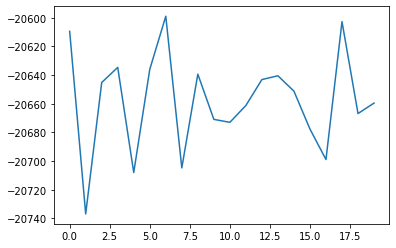

In [12]:
plt.plot(losses)